#Setup

In [ ]:
import os
import sys
import time
import csv
import numpy as np
import pickle
from PIL import Image
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torchvision
import torchvision.models as models  
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import PIL
from PIL import ImageDraw 
from tqdm import tqdm
import torch.optim as optim  
import torch.nn.functional as F
import json
import pandas as pd
from datetime import datetime
import pdb 
from google.colab import drive
from psutil import virtual_memory
from zipfile import ZipFile
from sklearn.cluster import KMeans
import xml.etree.ElementTree as ET
import torchvision.transforms as transforms
from sklearn.preprocessing import normalize

#Make sure to mount drive and that you have access to IDL_group_project. All paths are from the shared folder
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
pwd

'/content'

#Helper Functions

Below are functions for parsing through file structures

In [ ]:
#This function will return both the path and the file names of all files in a directory
def path_file_list_creator(path, both_path_file = False):
  path_file_list = []
  for myfile in os.listdir(path):
    full_path = os.path.join(path,myfile)
    if both_path_file == True:
      path_file_list.append((full_path, myfile))
    else:
      path_file_list.append(full_path)

  return(path_file_list,len(path_file_list))

#Concate all different classes semantic information together from seperate directories
def concate_directories(paths):
  semantic_bundles_paths_extended = []
  total_files = 0 

  for path in paths:
    class_bundle_paths , num_files = path_file_list_creator(path)
    semantic_bundles_paths_extended.extend(class_bundle_paths)
    total_files += num_files
  print("Total Files grabbed ", total_files)
  return(semantic_bundles_paths_extended)

Below are functions for visualizing and masking images

In [ ]:
#This displays and masks an image. Can be used to verify correct semantic objects are extracted
def display_mask_image(binary_mask, image_path, label, semantic_type):
  binary_mask = np.stack([binary_mask, binary_mask, binary_mask], axis=2)
  image = Image.open(image_path)
  image = np.asarray(image)
  masked_image = binary_mask * image
  masked_image = Image.fromarray(masked_image)
  
  #Annotations
  print("Image File: ", image_path)
  print("Class: ", label)
  print("Semantic_type: ", semantic_type)
  display(masked_image)

#This masks a image and converts the image into a pytorch tensor
def convert_mask_image(binary_mask, image_path):
  binary_mask = np.stack([binary_mask, binary_mask, binary_mask], axis=2)
  image = Image.open(image_path)
  image = np.asarray(image)

  masked_image = binary_mask * image
  transforms = torchvision.transforms.Compose([torchvision.transforms.ToTensor(), 
                                                     torchvision.transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])
  #masked_image = torchvision.transforms.functional.to_tensor(masked_image)
  masked_image = transforms(masked_image)
  masked_image = torch.unsqueeze(masked_image, dim = 0)

  return(masked_image)

Below is the custom DataLoader

In [ ]:
class SemanticObjectsLoader(DataLoader):
  def __init__(self, paths, image_folder_path, target_lables):
    self.paths = concate_directories(paths)
    self.image_folder_dir = image_folder_path
    self.target_labels = target_labels
  def __iter__(self):

    for i, path in enumerate(self.paths):
      with open(path, 'rb') as f:
        data = pickle.load(f)
      image_name = data['image_name']
      #We must append the full path name to image_name
      image_name = self.image_folder_dir + image_name + '.jpg'
      num_objects = data["num_objects"]
      #we must iterate through every different object (for example there could be two airplanes in one photo)
      for object_index in range(num_objects):
        #Crawling through each object index
        label = data['objects_list'][object_index]['obj_class']
        if label in self.target_labels:
         
          #We must iterate through every semantic item now
          for semantic_index in range(len(data['objects_list'][object_index]['parts_list'])):
            semantic_mask = data['objects_list'][object_index]['parts_list'][semantic_index]['part_mask']
            semantic_type = data['objects_list'][object_index]['parts_list'][semantic_index]['part_name']
            #Fill in a new entry into the dictionary
            meta_dict = {"image_name": image_name, "label" : label, "semantic_mask" : semantic_mask, "semantic_type" :semantic_type}
            yield meta_dict

    yield full_semantic_list_getter(self.paths)

Returns a list of feature vectors with dimension 512 that contain nonzero values

In [ ]:
def get_nonzero_feature_vectors(max_pool_layer_4_representation):
  max_pool_layer_4_representation = max_pool_layer_4_representation.detach().cpu()
  batch_indices, channel_indices, width_idices, height_indices = torch.nonzero(max_pool_layer_4_representation, as_tuple=True)
  feature_vector_list = []
  for non_zero_index in range(len(batch_indices)):
    feature_vector = max_pool_layer_4_representation[0, : ,width_idices[non_zero_index], height_indices[non_zero_index]].numpy()
    feature_vector_list.append(feature_vector)
  return(feature_vector_list)


#Visualizing Masks

In [ ]:
aeroplane_annotations_path = '/content/drive/MyDrive/IDL_group_project/Google_Colab/data/PASCAL-Part-anno-pkl/aeroplane'
bicycle_annotations_path = '/content/drive/MyDrive/IDL_group_project/Google_Colab/data/PASCAL-Part-anno-pkl/bicycle'
#boat_annotations_path = '/content/drive/MyDrive/IDL_group_project/Google_Colab/data/PASCAL-Part-anno-pkl/boat'
bus_annotations_path = '/content/drive/MyDrive/IDL_group_project/Google_Colab/data/PASCAL-Part-anno-pkl/bus'
car_annotations_path = '/content/drive/MyDrive/IDL_group_project/Google_Colab/data/PASCAL-Part-anno-pkl/car'
motorbike_annotations_path = '/content/drive/MyDrive/IDL_group_project/Google_Colab/data/PASCAL-Part-anno-pkl/motorbike'
train_annotations_path = '/content/drive/MyDrive/IDL_group_project/Google_Colab/data/PASCAL-Part-anno-pkl/train'
image_folder_dir = '/content/drive/MyDrive/IDL_group_project/Data/VOCdevkit/VOC2010/JPEGImages/'
#target_labels = ['aeroplane', 'bicycle', 'boat', 'bus', 'car', 'motorbike', 'train']
target_labels = ['aeroplane', 'bicycle', 'bus', 'car', 'motorbike', 'train']

In [ ]:
all_classes_semantic_paths = [aeroplane_annotations_path,bicycle_annotations_path,bus_annotations_path,car_annotations_path,motorbike_annotations_path,train_annotations_path]
semantic_dataloader = SemanticObjectsLoader(all_classes_semantic_paths, image_folder_dir, all_classes_semantic_paths)

Total Files grabbed  3351


In [ ]:
print(model)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (17): Conv2d(256, 512, kernel_si

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)
model = models.vgg16(pretrained=True).features[:24].to(device)

cpu


Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

Image File:  /content/drive/MyDrive/IDL_group_project/Data/VOCdevkit/VOC2010/JPEGImages/2008_000501.jpg
Class:  car
Semantic_type:  bliplate


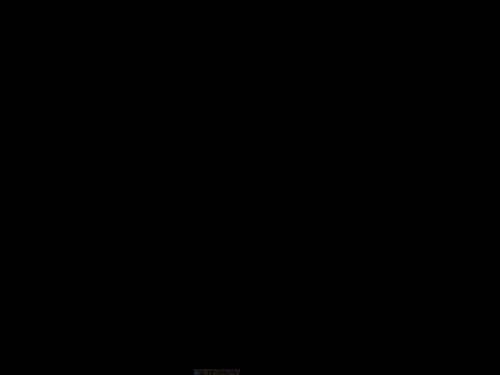

Image File:  /content/drive/MyDrive/IDL_group_project/Data/VOCdevkit/VOC2010/JPEGImages/2008_000501.jpg
Class:  car
Semantic_type:  backside


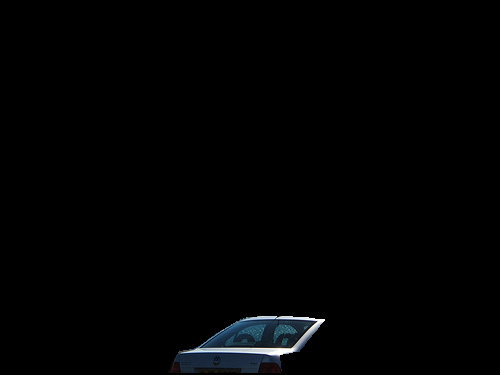

Image File:  /content/drive/MyDrive/IDL_group_project/Data/VOCdevkit/VOC2010/JPEGImages/2008_000501.jpg
Class:  car
Semantic_type:  rightside


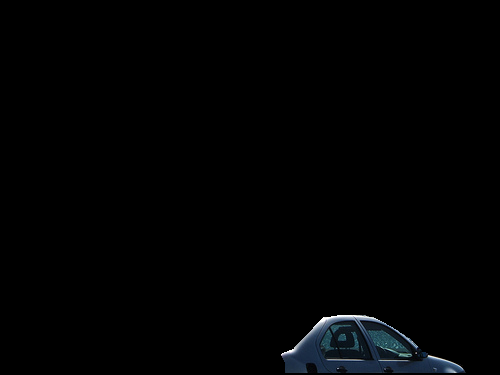

Image File:  /content/drive/MyDrive/IDL_group_project/Data/VOCdevkit/VOC2010/JPEGImages/2008_000501.jpg
Class:  car
Semantic_type:  door_1


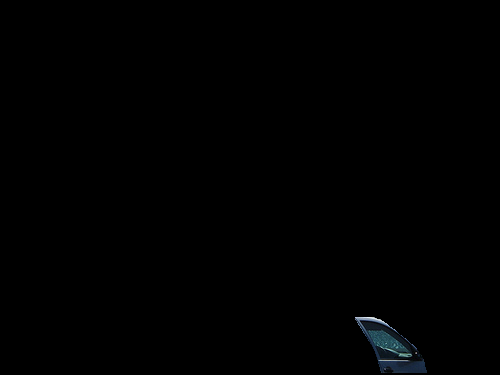

Image File:  /content/drive/MyDrive/IDL_group_project/Data/VOCdevkit/VOC2010/JPEGImages/2008_000501.jpg
Class:  car
Semantic_type:  door_2


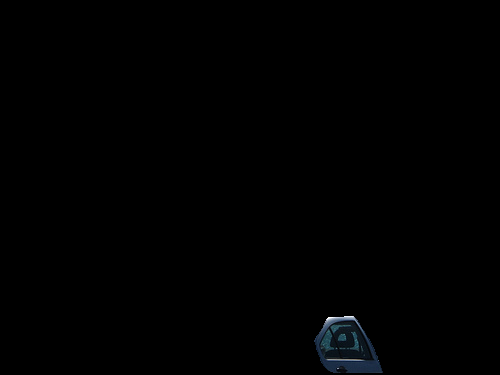

Image File:  /content/drive/MyDrive/IDL_group_project/Data/VOCdevkit/VOC2010/JPEGImages/2008_000501.jpg
Class:  car
Semantic_type:  rightmirror


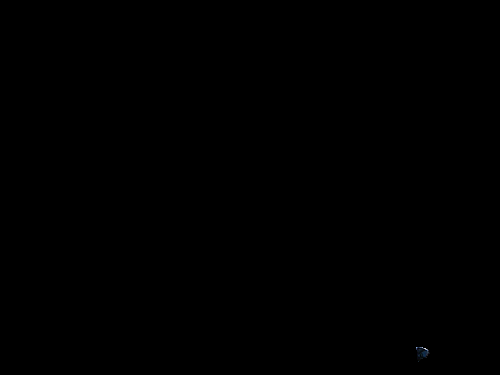

Image File:  /content/drive/MyDrive/IDL_group_project/Data/VOCdevkit/VOC2010/JPEGImages/2008_000501.jpg
Class:  car
Semantic_type:  window_1


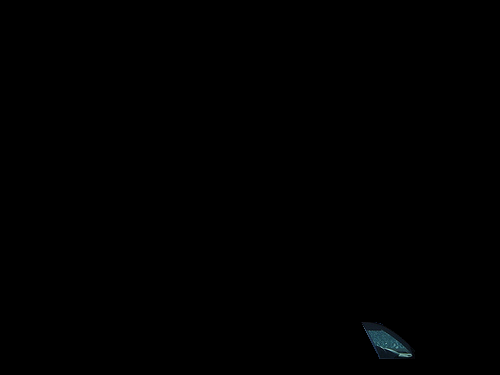

Image File:  /content/drive/MyDrive/IDL_group_project/Data/VOCdevkit/VOC2010/JPEGImages/2008_000501.jpg
Class:  car
Semantic_type:  window_2


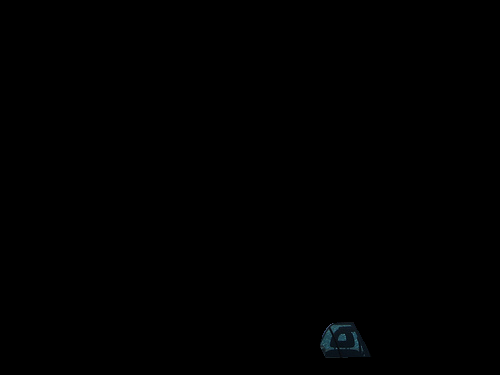

Image File:  /content/drive/MyDrive/IDL_group_project/Data/VOCdevkit/VOC2010/JPEGImages/2008_000501.jpg
Class:  car
Semantic_type:  window_3


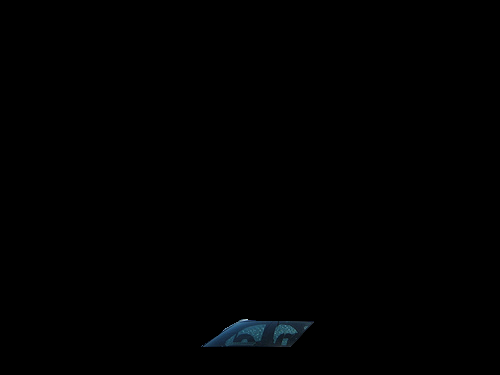

Image File:  /content/drive/MyDrive/IDL_group_project/Data/VOCdevkit/VOC2010/JPEGImages/2008_000531.jpg
Class:  bicycle
Semantic_type:  fwheel


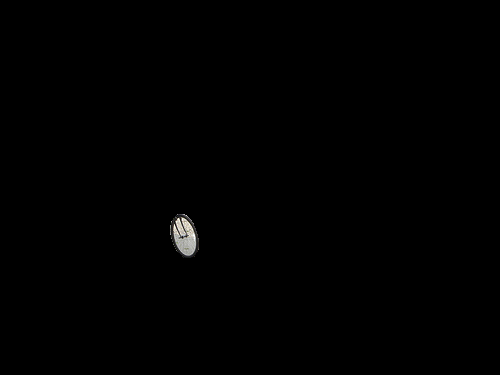

Image File:  /content/drive/MyDrive/IDL_group_project/Data/VOCdevkit/VOC2010/JPEGImages/2008_000531.jpg
Class:  bicycle
Semantic_type:  bwheel


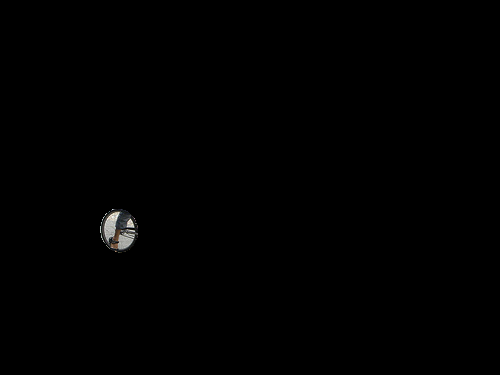

Image File:  /content/drive/MyDrive/IDL_group_project/Data/VOCdevkit/VOC2010/JPEGImages/2008_000531.jpg
Class:  bicycle
Semantic_type:  chainwheel


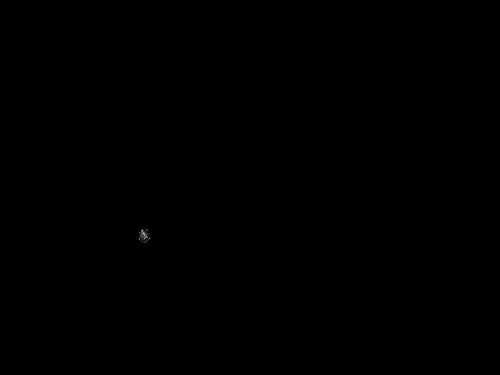

Image File:  /content/drive/MyDrive/IDL_group_project/Data/VOCdevkit/VOC2010/JPEGImages/2008_000531.jpg
Class:  bicycle
Semantic_type:  handlebar


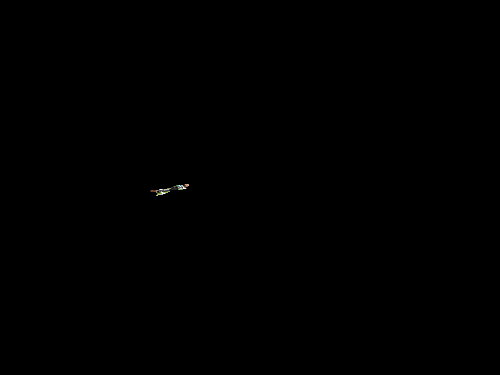

Image File:  /content/drive/MyDrive/IDL_group_project/Data/VOCdevkit/VOC2010/JPEGImages/2008_000531.jpg
Class:  car
Semantic_type:  backside


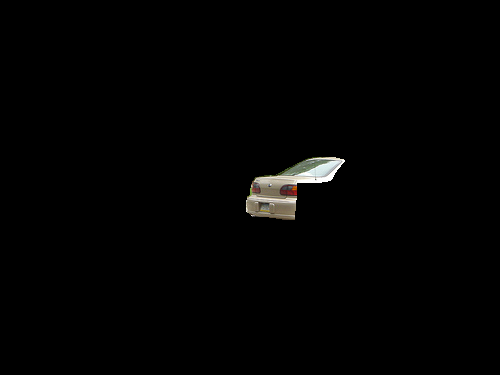

Image File:  /content/drive/MyDrive/IDL_group_project/Data/VOCdevkit/VOC2010/JPEGImages/2008_000531.jpg
Class:  car
Semantic_type:  rightside


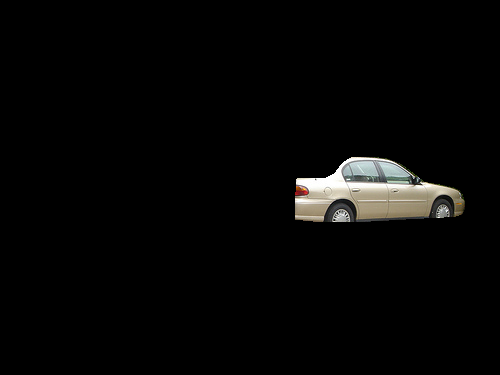

Image File:  /content/drive/MyDrive/IDL_group_project/Data/VOCdevkit/VOC2010/JPEGImages/2008_000531.jpg
Class:  car
Semantic_type:  door_1


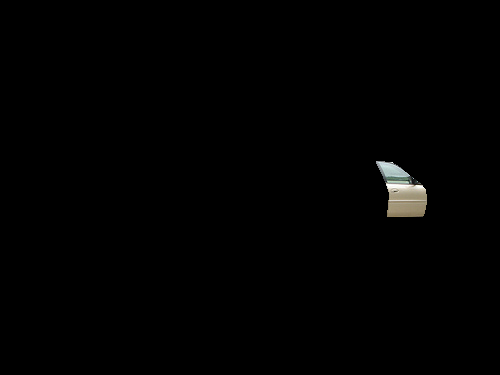

Image File:  /content/drive/MyDrive/IDL_group_project/Data/VOCdevkit/VOC2010/JPEGImages/2008_000531.jpg
Class:  car
Semantic_type:  door_2


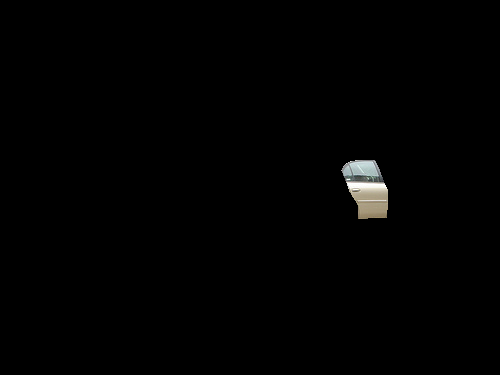

Image File:  /content/drive/MyDrive/IDL_group_project/Data/VOCdevkit/VOC2010/JPEGImages/2008_000531.jpg
Class:  car
Semantic_type:  rightmirror


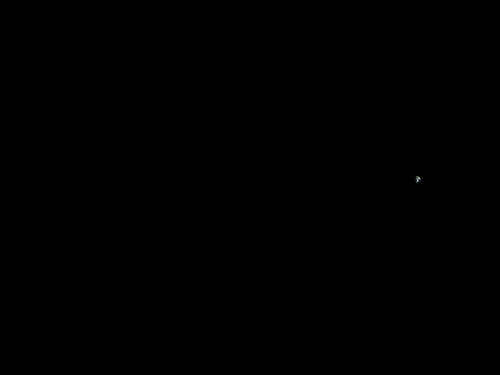

Image File:  /content/drive/MyDrive/IDL_group_project/Data/VOCdevkit/VOC2010/JPEGImages/2008_000531.jpg
Class:  car
Semantic_type:  wheel_1


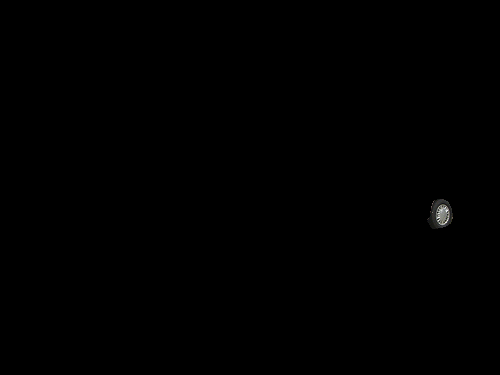

Image File:  /content/drive/MyDrive/IDL_group_project/Data/VOCdevkit/VOC2010/JPEGImages/2008_000531.jpg
Class:  car
Semantic_type:  wheel_2


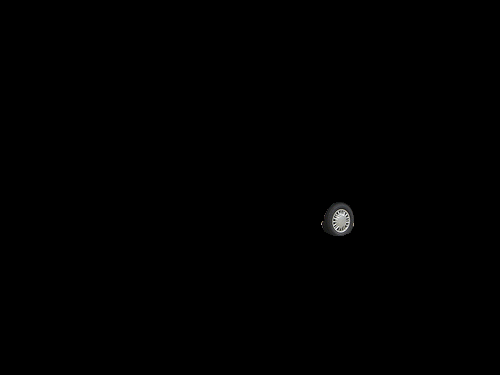

Image File:  /content/drive/MyDrive/IDL_group_project/Data/VOCdevkit/VOC2010/JPEGImages/2008_000531.jpg
Class:  car
Semantic_type:  window_1


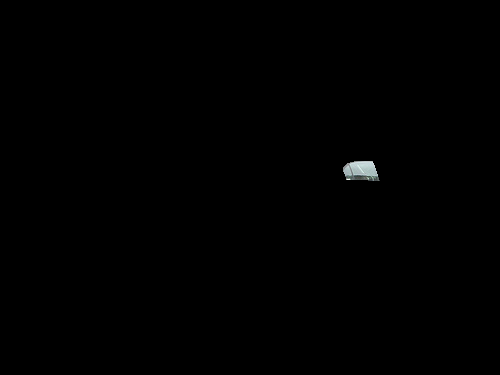

Image File:  /content/drive/MyDrive/IDL_group_project/Data/VOCdevkit/VOC2010/JPEGImages/2008_000531.jpg
Class:  car
Semantic_type:  window_2


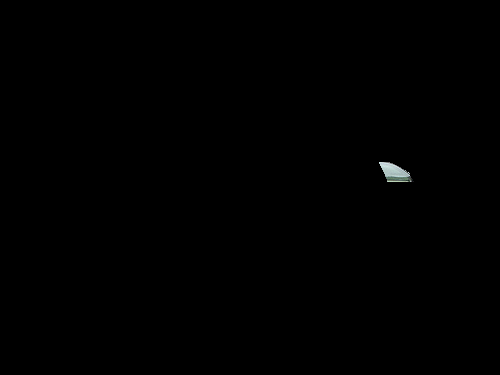

Image File:  /content/drive/MyDrive/IDL_group_project/Data/VOCdevkit/VOC2010/JPEGImages/2008_000531.jpg
Class:  car
Semantic_type:  window_3


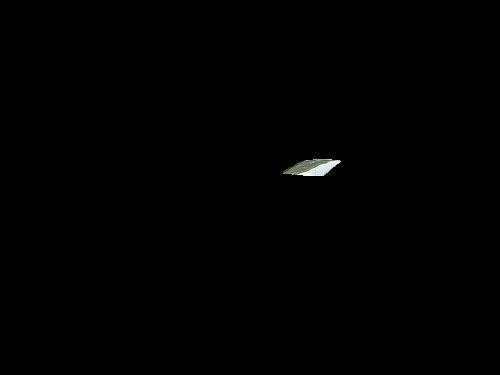

Image File:  /content/drive/MyDrive/IDL_group_project/Data/VOCdevkit/VOC2010/JPEGImages/2008_000562.jpg
Class:  car
Semantic_type:  backside


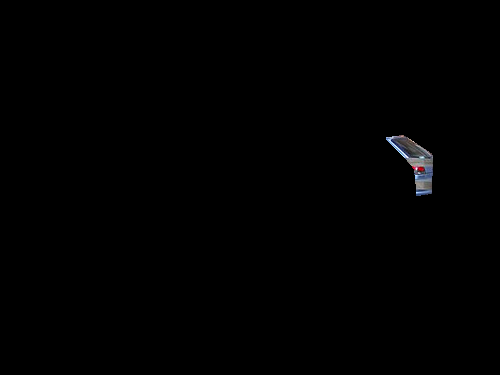

Image File:  /content/drive/MyDrive/IDL_group_project/Data/VOCdevkit/VOC2010/JPEGImages/2008_000562.jpg
Class:  car
Semantic_type:  leftside


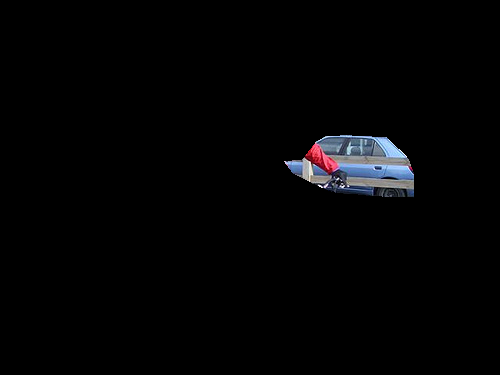

Image File:  /content/drive/MyDrive/IDL_group_project/Data/VOCdevkit/VOC2010/JPEGImages/2008_000562.jpg
Class:  car
Semantic_type:  wheel_1


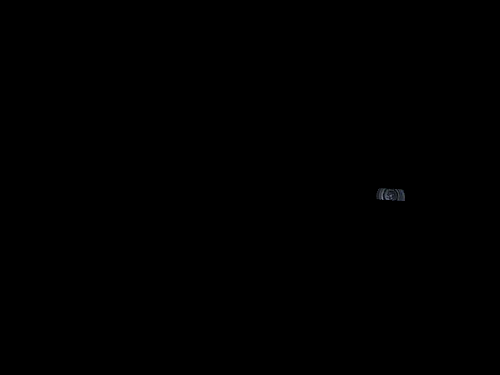

Image File:  /content/drive/MyDrive/IDL_group_project/Data/VOCdevkit/VOC2010/JPEGImages/2008_000562.jpg
Class:  car
Semantic_type:  window_1


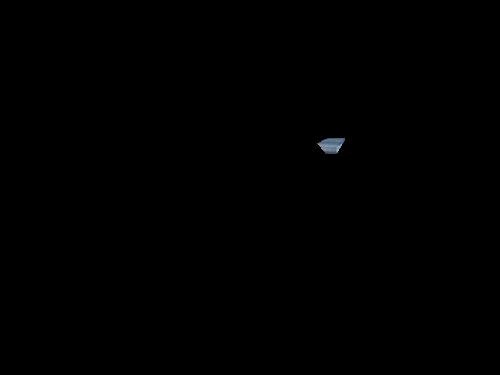

Image File:  /content/drive/MyDrive/IDL_group_project/Data/VOCdevkit/VOC2010/JPEGImages/2008_000562.jpg
Class:  car
Semantic_type:  window_2


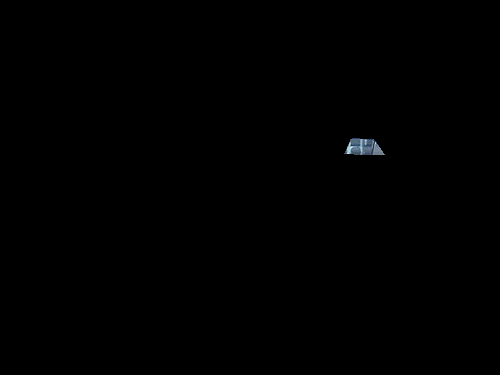

Image File:  /content/drive/MyDrive/IDL_group_project/Data/VOCdevkit/VOC2010/JPEGImages/2008_000562.jpg
Class:  car
Semantic_type:  window_3


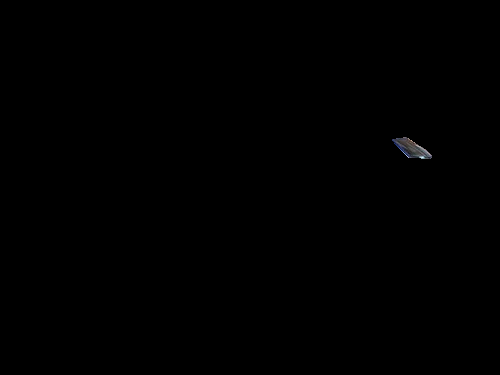

Image File:  /content/drive/MyDrive/IDL_group_project/Data/VOCdevkit/VOC2010/JPEGImages/2008_000562.jpg
Class:  bicycle
Semantic_type:  fwheel


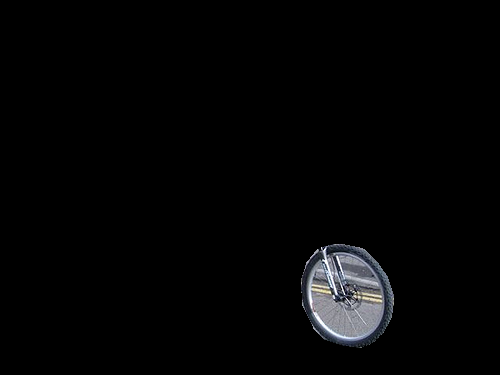

Image File:  /content/drive/MyDrive/IDL_group_project/Data/VOCdevkit/VOC2010/JPEGImages/2008_000562.jpg
Class:  bicycle
Semantic_type:  bwheel


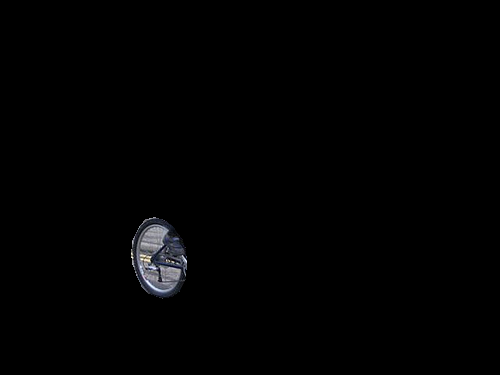

Image File:  /content/drive/MyDrive/IDL_group_project/Data/VOCdevkit/VOC2010/JPEGImages/2008_000562.jpg
Class:  bicycle
Semantic_type:  chainwheel


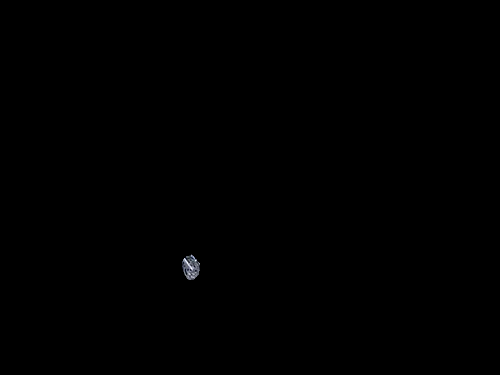

Image File:  /content/drive/MyDrive/IDL_group_project/Data/VOCdevkit/VOC2010/JPEGImages/2008_000562.jpg
Class:  bicycle
Semantic_type:  handlebar


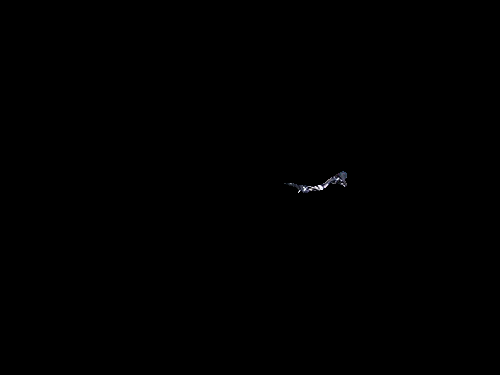

Image File:  /content/drive/MyDrive/IDL_group_project/Data/VOCdevkit/VOC2010/JPEGImages/2008_000563.jpg
Class:  car
Semantic_type:  frontside


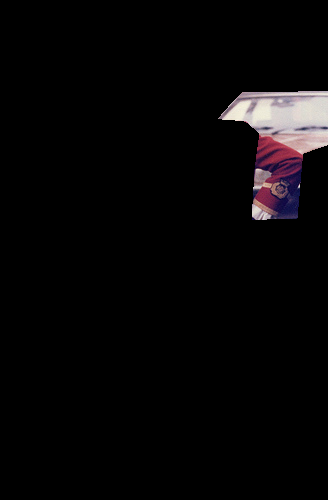

Image File:  /content/drive/MyDrive/IDL_group_project/Data/VOCdevkit/VOC2010/JPEGImages/2008_000563.jpg
Class:  car
Semantic_type:  leftside


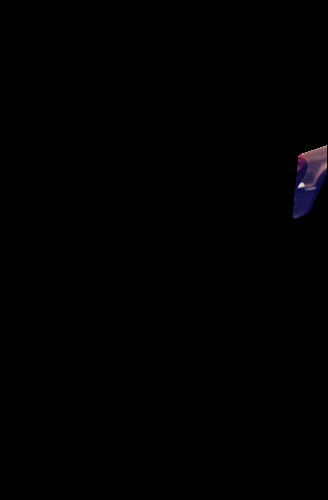

Image File:  /content/drive/MyDrive/IDL_group_project/Data/VOCdevkit/VOC2010/JPEGImages/2008_000563.jpg
Class:  car
Semantic_type:  headlight_1


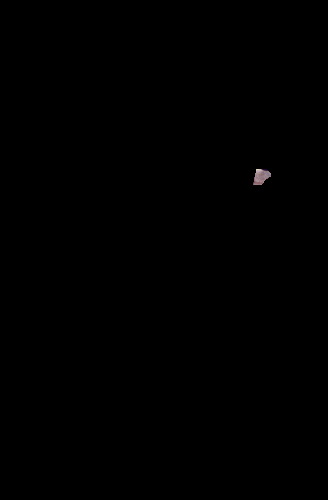

Image File:  /content/drive/MyDrive/IDL_group_project/Data/VOCdevkit/VOC2010/JPEGImages/2008_000563.jpg
Class:  car
Semantic_type:  window_1


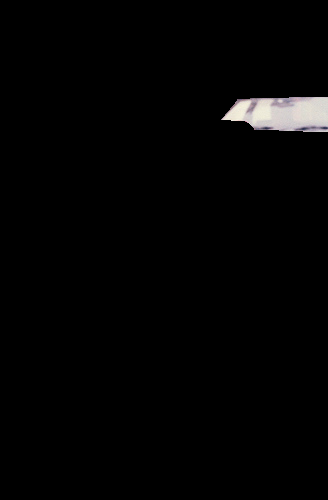

Image File:  /content/drive/MyDrive/IDL_group_project/Data/VOCdevkit/VOC2010/JPEGImages/2008_000563.jpg
Class:  motorbike
Semantic_type:  fwheel


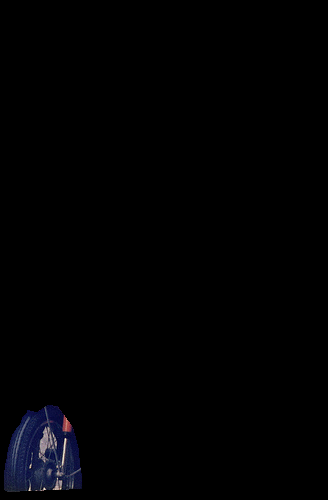

Image File:  /content/drive/MyDrive/IDL_group_project/Data/VOCdevkit/VOC2010/JPEGImages/2008_000563.jpg
Class:  motorbike
Semantic_type:  bwheel


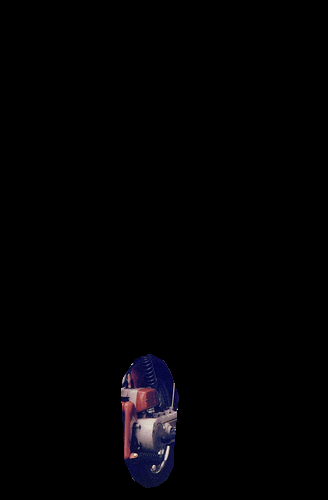

Image File:  /content/drive/MyDrive/IDL_group_project/Data/VOCdevkit/VOC2010/JPEGImages/2008_000563.jpg
Class:  motorbike
Semantic_type:  headlight_1


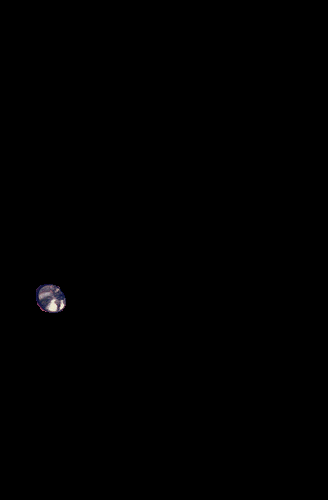

Image File:  /content/drive/MyDrive/IDL_group_project/Data/VOCdevkit/VOC2010/JPEGImages/2008_000583.jpg
Class:  car
Semantic_type:  backside


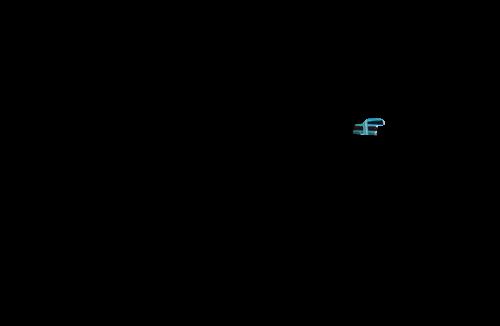

Image File:  /content/drive/MyDrive/IDL_group_project/Data/VOCdevkit/VOC2010/JPEGImages/2008_000583.jpg
Class:  car
Semantic_type:  rightside


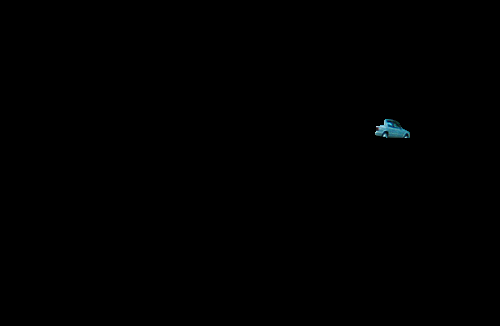

Image File:  /content/drive/MyDrive/IDL_group_project/Data/VOCdevkit/VOC2010/JPEGImages/2008_000583.jpg
Class:  car
Semantic_type:  wheel_1


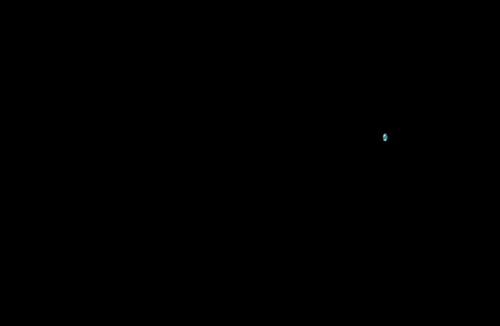

Image File:  /content/drive/MyDrive/IDL_group_project/Data/VOCdevkit/VOC2010/JPEGImages/2008_000583.jpg
Class:  car
Semantic_type:  wheel_2


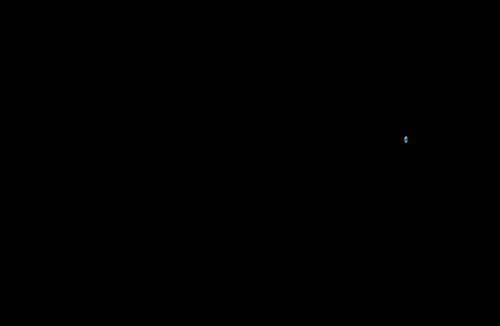

Image File:  /content/drive/MyDrive/IDL_group_project/Data/VOCdevkit/VOC2010/JPEGImages/2008_000583.jpg
Class:  car
Semantic_type:  window_1


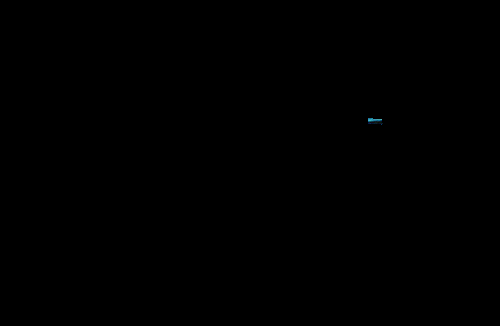

Image File:  /content/drive/MyDrive/IDL_group_project/Data/VOCdevkit/VOC2010/JPEGImages/2008_000583.jpg
Class:  car
Semantic_type:  window_2


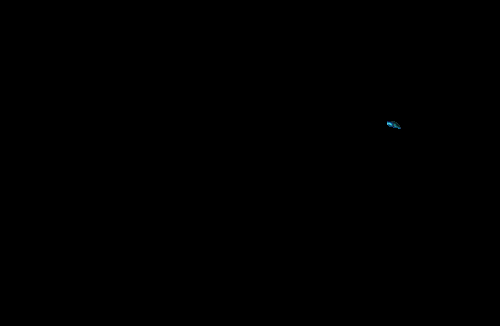

Image File:  /content/drive/MyDrive/IDL_group_project/Data/VOCdevkit/VOC2010/JPEGImages/2008_000595.jpg
Class:  car
Semantic_type:  frontside


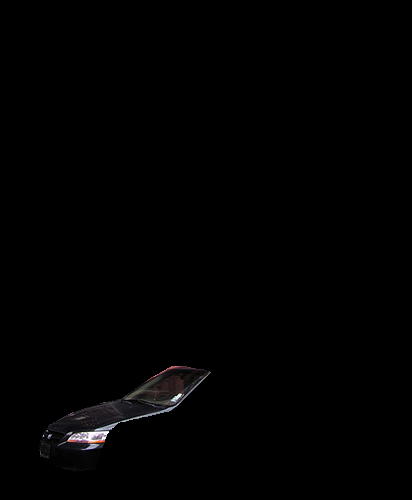

Image File:  /content/drive/MyDrive/IDL_group_project/Data/VOCdevkit/VOC2010/JPEGImages/2008_000595.jpg
Class:  car
Semantic_type:  leftside


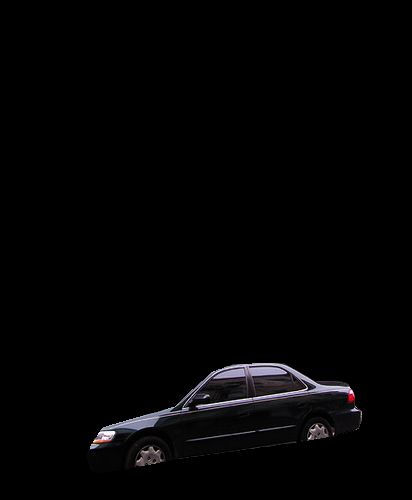

Image File:  /content/drive/MyDrive/IDL_group_project/Data/VOCdevkit/VOC2010/JPEGImages/2008_000595.jpg
Class:  car
Semantic_type:  leftmirror


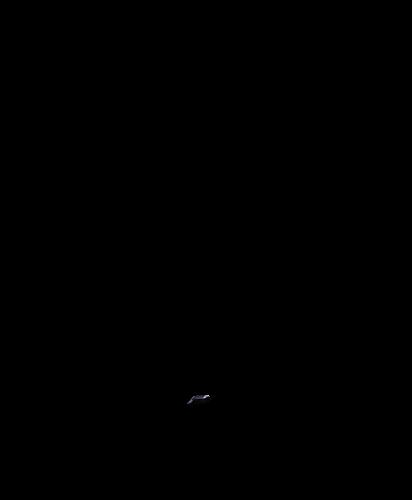

Image File:  /content/drive/MyDrive/IDL_group_project/Data/VOCdevkit/VOC2010/JPEGImages/2008_000595.jpg
Class:  car
Semantic_type:  headlight_1


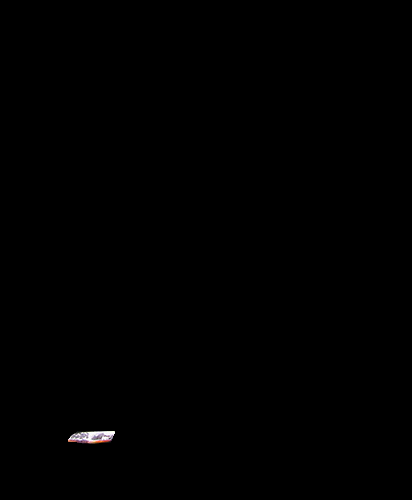

Image File:  /content/drive/MyDrive/IDL_group_project/Data/VOCdevkit/VOC2010/JPEGImages/2008_000595.jpg
Class:  car
Semantic_type:  wheel_1


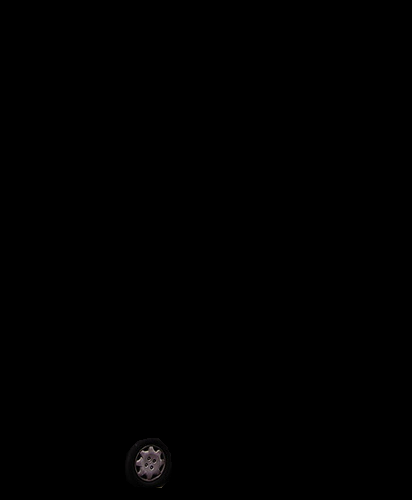

Image File:  /content/drive/MyDrive/IDL_group_project/Data/VOCdevkit/VOC2010/JPEGImages/2008_000595.jpg
Class:  car
Semantic_type:  wheel_2


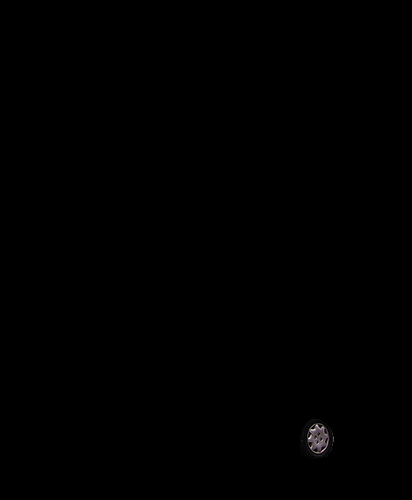

Image File:  /content/drive/MyDrive/IDL_group_project/Data/VOCdevkit/VOC2010/JPEGImages/2008_000595.jpg
Class:  car
Semantic_type:  window_1


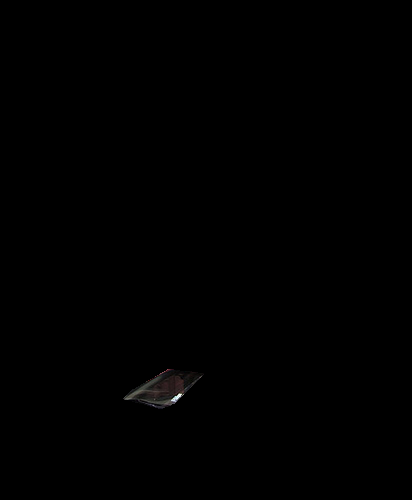

Image File:  /content/drive/MyDrive/IDL_group_project/Data/VOCdevkit/VOC2010/JPEGImages/2008_000595.jpg
Class:  car
Semantic_type:  window_2


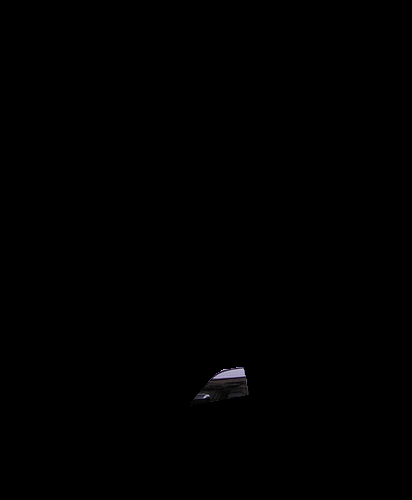

Image File:  /content/drive/MyDrive/IDL_group_project/Data/VOCdevkit/VOC2010/JPEGImages/2008_000595.jpg
Class:  car
Semantic_type:  window_3


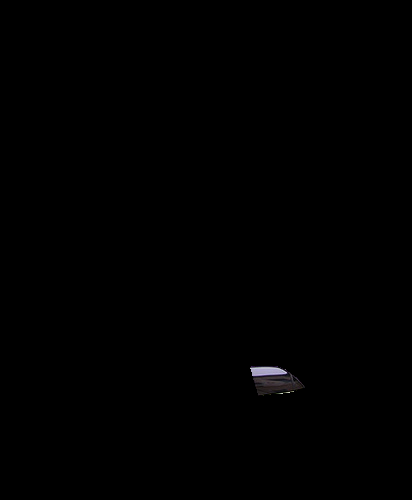

Image File:  /content/drive/MyDrive/IDL_group_project/Data/VOCdevkit/VOC2010/JPEGImages/2008_000599.jpg
Class:  car
Semantic_type:  frontside


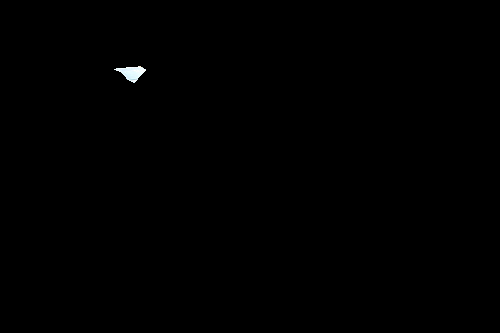

Image File:  /content/drive/MyDrive/IDL_group_project/Data/VOCdevkit/VOC2010/JPEGImages/2008_000599.jpg
Class:  car
Semantic_type:  rightside


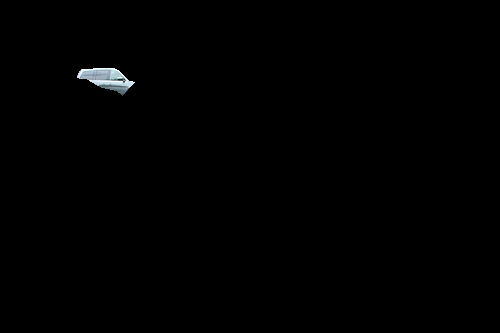

Image File:  /content/drive/MyDrive/IDL_group_project/Data/VOCdevkit/VOC2010/JPEGImages/2008_000599.jpg
Class:  car
Semantic_type:  rightmirror


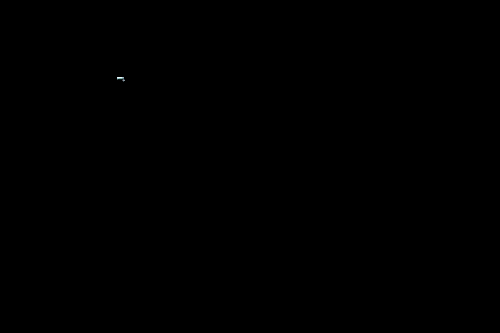

Image File:  /content/drive/MyDrive/IDL_group_project/Data/VOCdevkit/VOC2010/JPEGImages/2008_000599.jpg
Class:  car
Semantic_type:  window_1


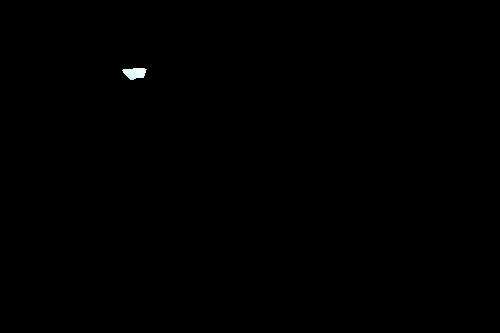

Image File:  /content/drive/MyDrive/IDL_group_project/Data/VOCdevkit/VOC2010/JPEGImages/2008_000599.jpg
Class:  car
Semantic_type:  window_2


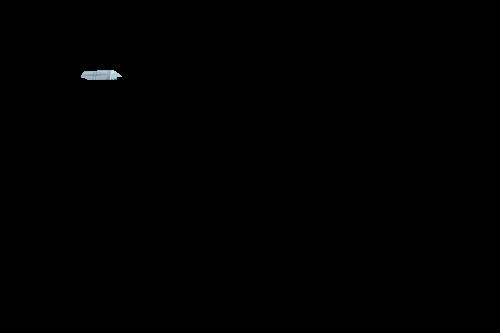

Image File:  /content/drive/MyDrive/IDL_group_project/Data/VOCdevkit/VOC2010/JPEGImages/2008_000599.jpg
Class:  car
Semantic_type:  frontside


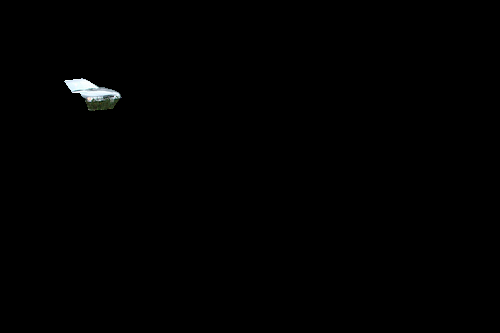

Image File:  /content/drive/MyDrive/IDL_group_project/Data/VOCdevkit/VOC2010/JPEGImages/2008_000599.jpg
Class:  car
Semantic_type:  rightside


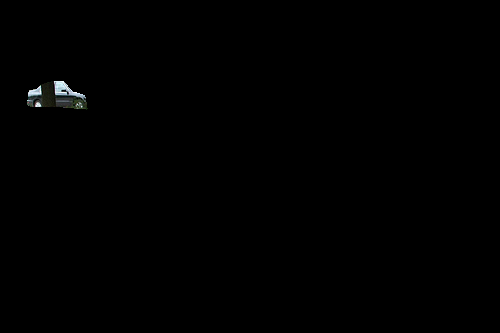

Image File:  /content/drive/MyDrive/IDL_group_project/Data/VOCdevkit/VOC2010/JPEGImages/2008_000599.jpg
Class:  car
Semantic_type:  rightmirror


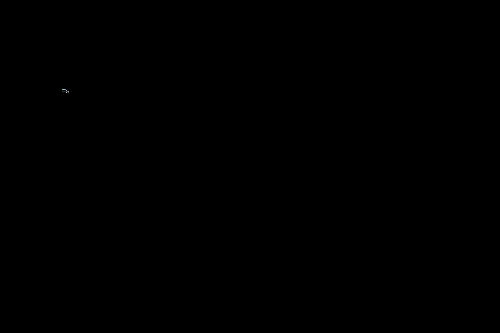

Image File:  /content/drive/MyDrive/IDL_group_project/Data/VOCdevkit/VOC2010/JPEGImages/2008_000599.jpg
Class:  car
Semantic_type:  headlight_1


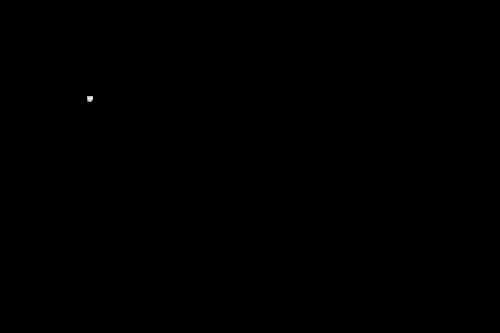

Image File:  /content/drive/MyDrive/IDL_group_project/Data/VOCdevkit/VOC2010/JPEGImages/2008_000599.jpg
Class:  car
Semantic_type:  wheel_1


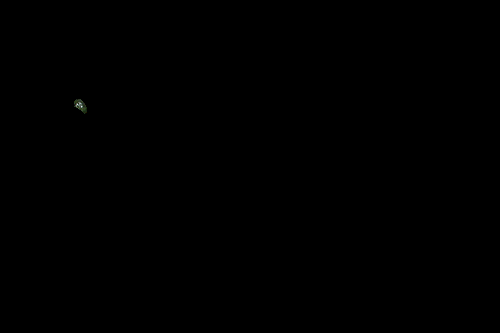

Image File:  /content/drive/MyDrive/IDL_group_project/Data/VOCdevkit/VOC2010/JPEGImages/2008_000599.jpg
Class:  car
Semantic_type:  wheel_2


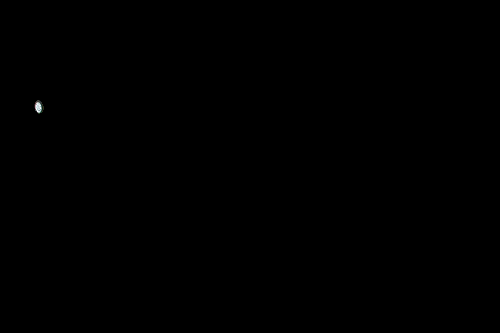

Image File:  /content/drive/MyDrive/IDL_group_project/Data/VOCdevkit/VOC2010/JPEGImages/2008_000599.jpg
Class:  car
Semantic_type:  window_1


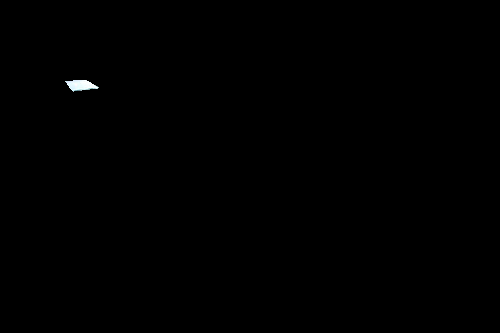

Image File:  /content/drive/MyDrive/IDL_group_project/Data/VOCdevkit/VOC2010/JPEGImages/2008_000599.jpg
Class:  car
Semantic_type:  window_2


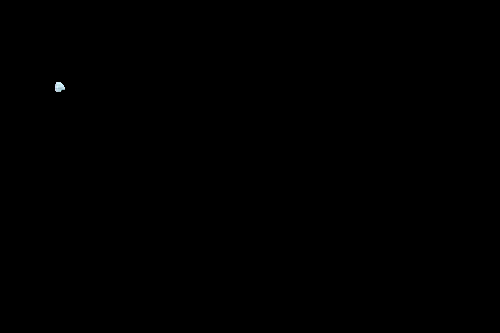

Image File:  /content/drive/MyDrive/IDL_group_project/Data/VOCdevkit/VOC2010/JPEGImages/2008_000599.jpg
Class:  car
Semantic_type:  frontside


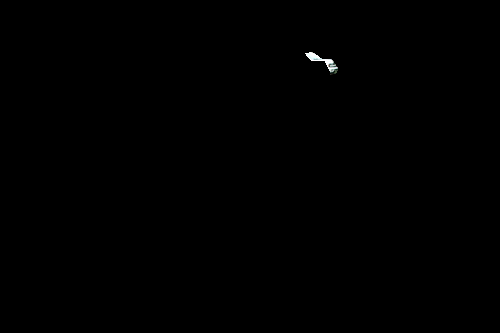

Image File:  /content/drive/MyDrive/IDL_group_project/Data/VOCdevkit/VOC2010/JPEGImages/2008_000599.jpg
Class:  car
Semantic_type:  rightside


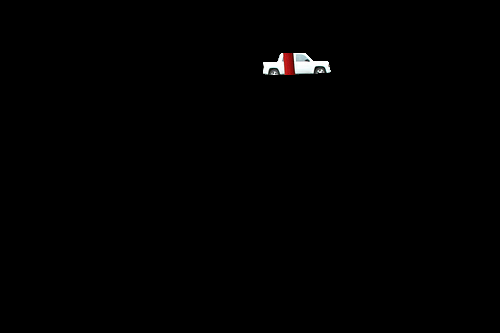

Image File:  /content/drive/MyDrive/IDL_group_project/Data/VOCdevkit/VOC2010/JPEGImages/2008_000599.jpg
Class:  car
Semantic_type:  rightmirror


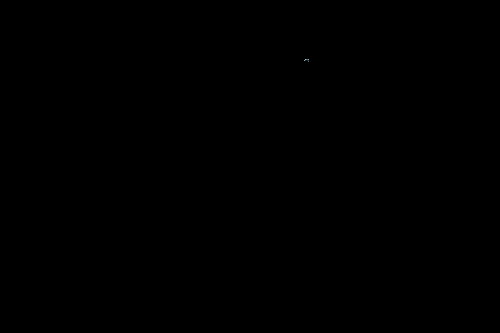

Image File:  /content/drive/MyDrive/IDL_group_project/Data/VOCdevkit/VOC2010/JPEGImages/2008_000599.jpg
Class:  car
Semantic_type:  wheel_1


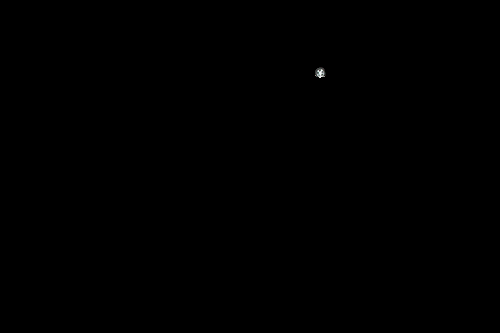

Image File:  /content/drive/MyDrive/IDL_group_project/Data/VOCdevkit/VOC2010/JPEGImages/2008_000599.jpg
Class:  car
Semantic_type:  wheel_2


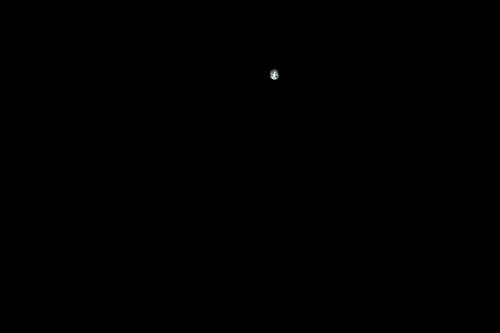

Image File:  /content/drive/MyDrive/IDL_group_project/Data/VOCdevkit/VOC2010/JPEGImages/2008_000599.jpg
Class:  car
Semantic_type:  window_1


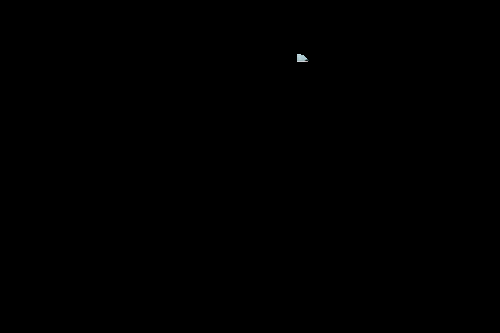

Image File:  /content/drive/MyDrive/IDL_group_project/Data/VOCdevkit/VOC2010/JPEGImages/2008_000613.jpg
Class:  car
Semantic_type:  frontside


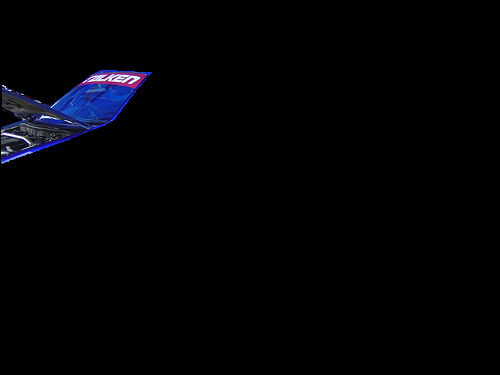

Image File:  /content/drive/MyDrive/IDL_group_project/Data/VOCdevkit/VOC2010/JPEGImages/2008_000613.jpg
Class:  car
Semantic_type:  leftside


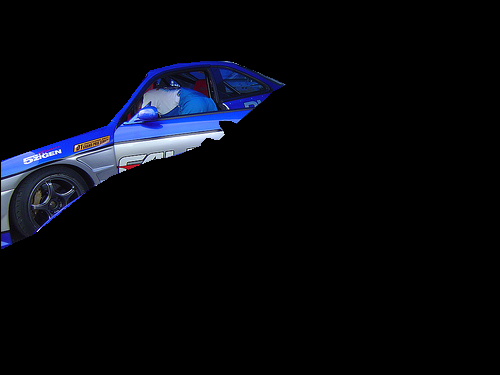

Image File:  /content/drive/MyDrive/IDL_group_project/Data/VOCdevkit/VOC2010/JPEGImages/2008_000613.jpg
Class:  car
Semantic_type:  door_1


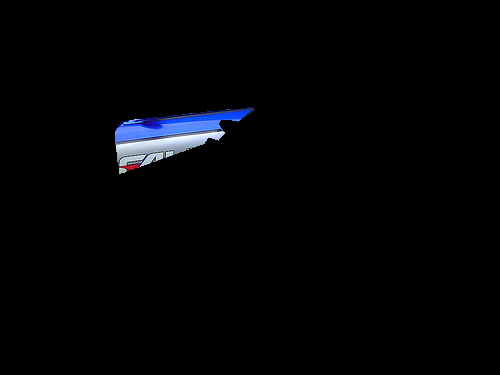

Image File:  /content/drive/MyDrive/IDL_group_project/Data/VOCdevkit/VOC2010/JPEGImages/2008_000613.jpg
Class:  car
Semantic_type:  leftmirror


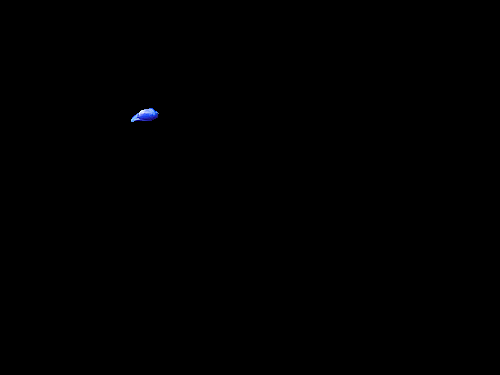

Image File:  /content/drive/MyDrive/IDL_group_project/Data/VOCdevkit/VOC2010/JPEGImages/2008_000613.jpg
Class:  car
Semantic_type:  wheel_1


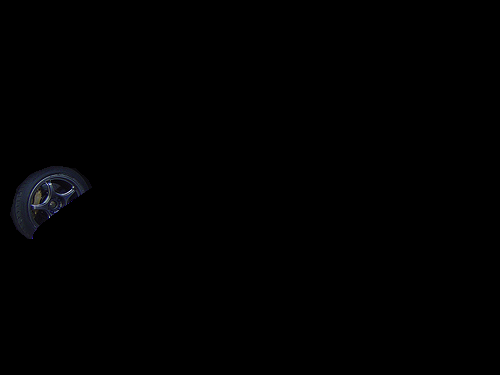

Image File:  /content/drive/MyDrive/IDL_group_project/Data/VOCdevkit/VOC2010/JPEGImages/2008_000613.jpg
Class:  car
Semantic_type:  window_1


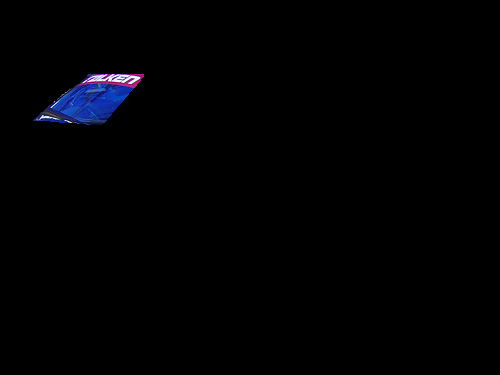

Image File:  /content/drive/MyDrive/IDL_group_project/Data/VOCdevkit/VOC2010/JPEGImages/2008_000613.jpg
Class:  car
Semantic_type:  frontside


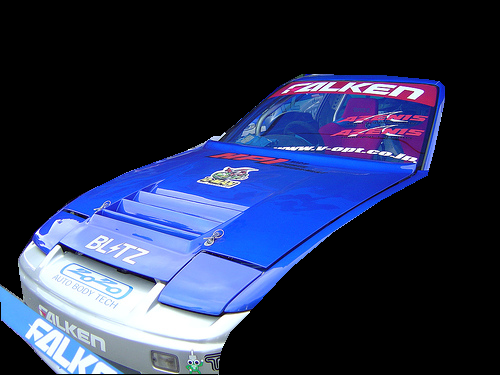

Image File:  /content/drive/MyDrive/IDL_group_project/Data/VOCdevkit/VOC2010/JPEGImages/2008_000613.jpg
Class:  car
Semantic_type:  leftside


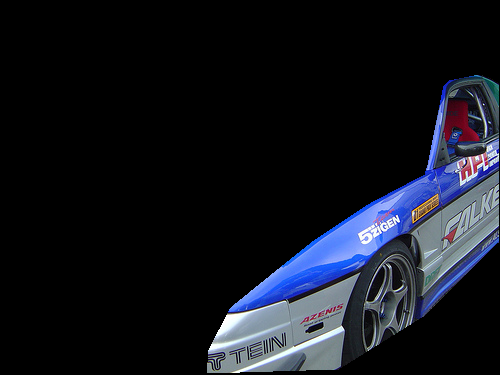

Image File:  /content/drive/MyDrive/IDL_group_project/Data/VOCdevkit/VOC2010/JPEGImages/2008_000613.jpg
Class:  car
Semantic_type:  leftmirror


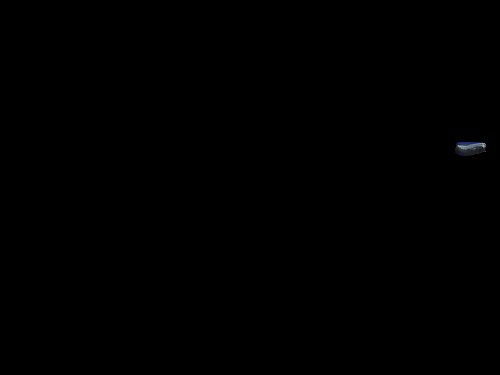

Image File:  /content/drive/MyDrive/IDL_group_project/Data/VOCdevkit/VOC2010/JPEGImages/2008_000613.jpg
Class:  car
Semantic_type:  rightmirror


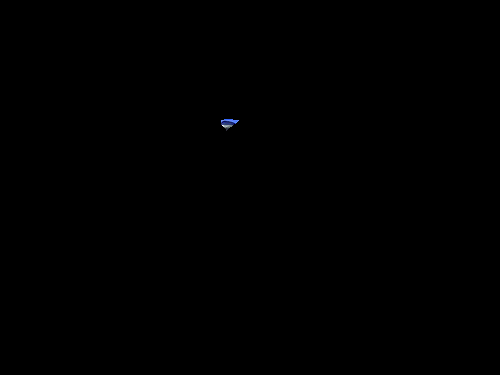

Image File:  /content/drive/MyDrive/IDL_group_project/Data/VOCdevkit/VOC2010/JPEGImages/2008_000613.jpg
Class:  car
Semantic_type:  wheel_1


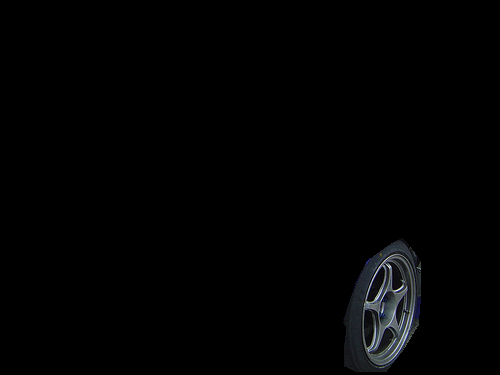

Image File:  /content/drive/MyDrive/IDL_group_project/Data/VOCdevkit/VOC2010/JPEGImages/2008_000613.jpg
Class:  car
Semantic_type:  window_1


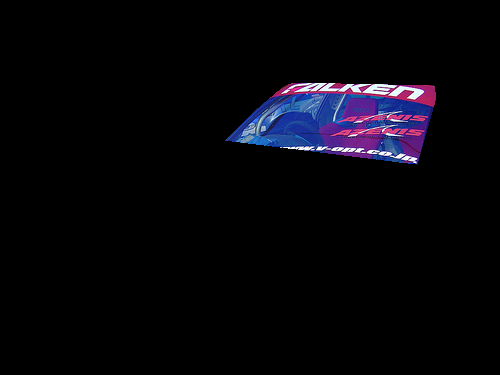

Image File:  /content/drive/MyDrive/IDL_group_project/Data/VOCdevkit/VOC2010/JPEGImages/2008_000619.jpg
Class:  car
Semantic_type:  bliplate


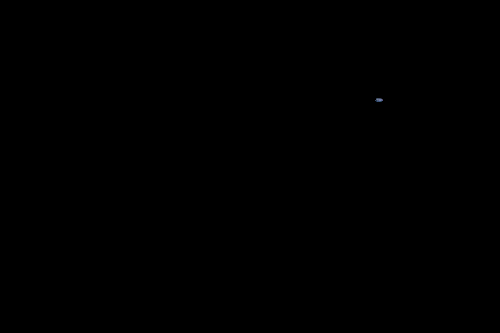

Image File:  /content/drive/MyDrive/IDL_group_project/Data/VOCdevkit/VOC2010/JPEGImages/2008_000619.jpg
Class:  car
Semantic_type:  backside


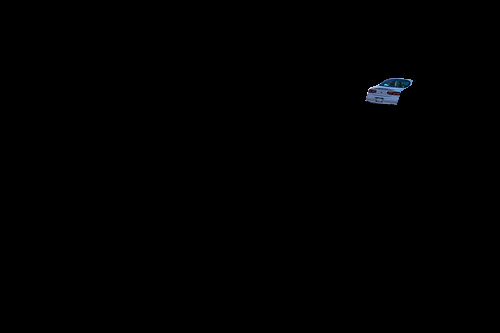

Image File:  /content/drive/MyDrive/IDL_group_project/Data/VOCdevkit/VOC2010/JPEGImages/2008_000619.jpg
Class:  car
Semantic_type:  rightside


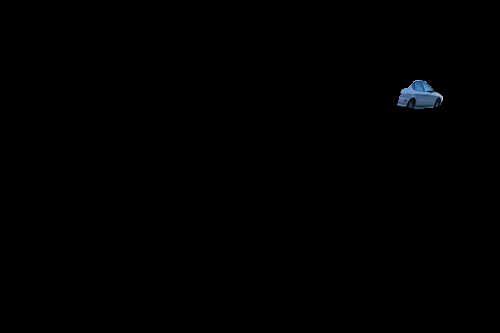

Image File:  /content/drive/MyDrive/IDL_group_project/Data/VOCdevkit/VOC2010/JPEGImages/2008_000619.jpg
Class:  car
Semantic_type:  wheel_1


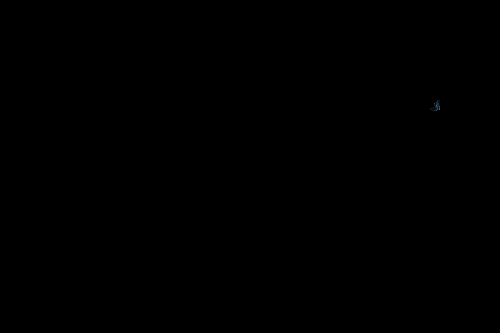

Image File:  /content/drive/MyDrive/IDL_group_project/Data/VOCdevkit/VOC2010/JPEGImages/2008_000619.jpg
Class:  car
Semantic_type:  wheel_2


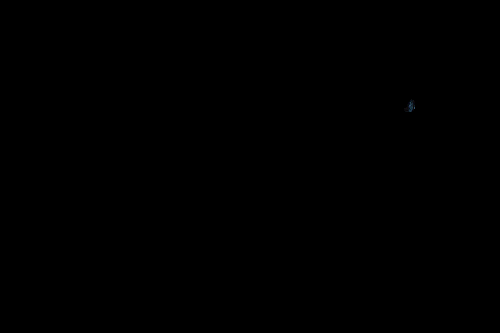

Image File:  /content/drive/MyDrive/IDL_group_project/Data/VOCdevkit/VOC2010/JPEGImages/2008_000619.jpg
Class:  car
Semantic_type:  window_1


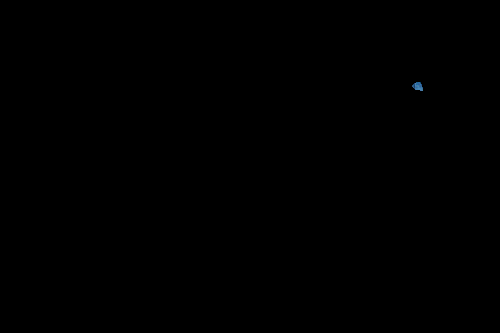

Image File:  /content/drive/MyDrive/IDL_group_project/Data/VOCdevkit/VOC2010/JPEGImages/2008_000619.jpg
Class:  car
Semantic_type:  window_2


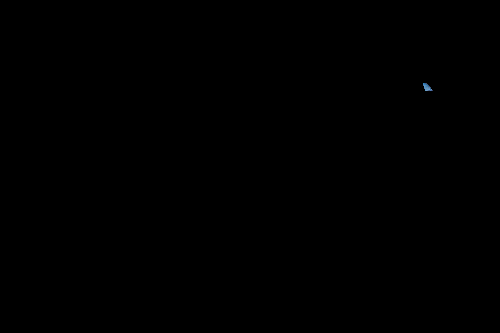

Image File:  /content/drive/MyDrive/IDL_group_project/Data/VOCdevkit/VOC2010/JPEGImages/2008_000619.jpg
Class:  car
Semantic_type:  window_3


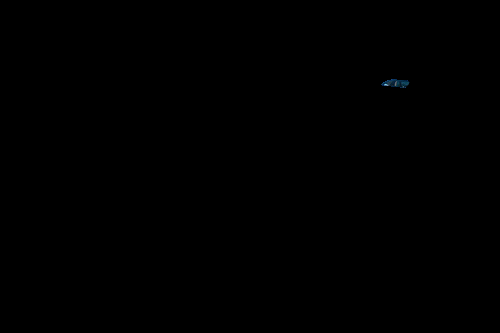

Image File:  /content/drive/MyDrive/IDL_group_project/Data/VOCdevkit/VOC2010/JPEGImages/2008_000619.jpg
Class:  car
Semantic_type:  bliplate


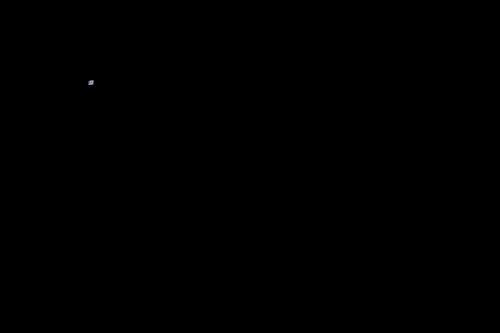

Image File:  /content/drive/MyDrive/IDL_group_project/Data/VOCdevkit/VOC2010/JPEGImages/2008_000619.jpg
Class:  car
Semantic_type:  backside


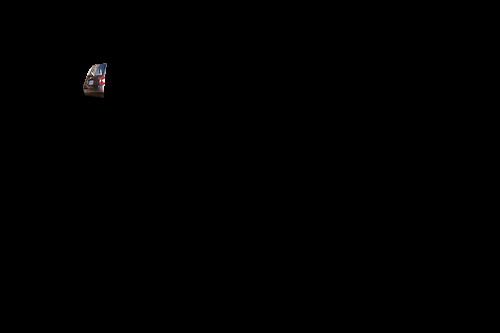

Image File:  /content/drive/MyDrive/IDL_group_project/Data/VOCdevkit/VOC2010/JPEGImages/2008_000619.jpg
Class:  car
Semantic_type:  rightside


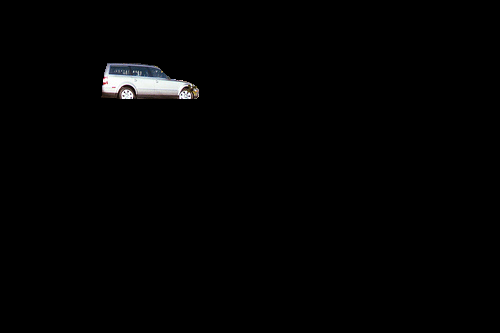

Image File:  /content/drive/MyDrive/IDL_group_project/Data/VOCdevkit/VOC2010/JPEGImages/2008_000619.jpg
Class:  car
Semantic_type:  door_1


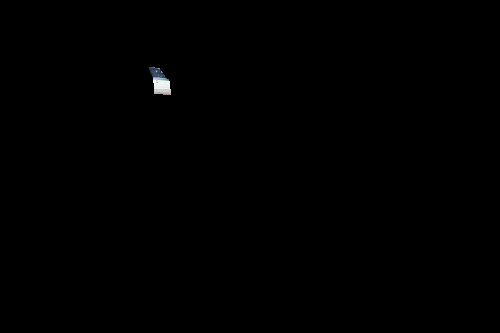

Image File:  /content/drive/MyDrive/IDL_group_project/Data/VOCdevkit/VOC2010/JPEGImages/2008_000619.jpg
Class:  car
Semantic_type:  door_2


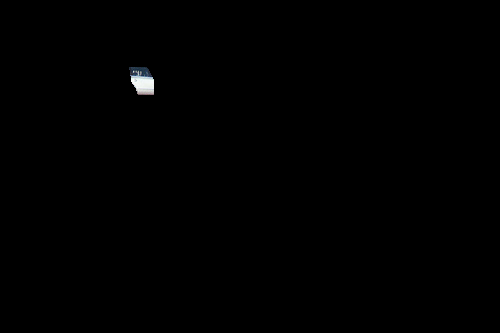

Image File:  /content/drive/MyDrive/IDL_group_project/Data/VOCdevkit/VOC2010/JPEGImages/2008_000619.jpg
Class:  car
Semantic_type:  rightmirror


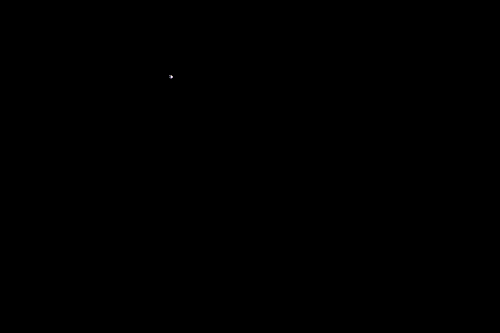

Image File:  /content/drive/MyDrive/IDL_group_project/Data/VOCdevkit/VOC2010/JPEGImages/2008_000619.jpg
Class:  car
Semantic_type:  wheel_1


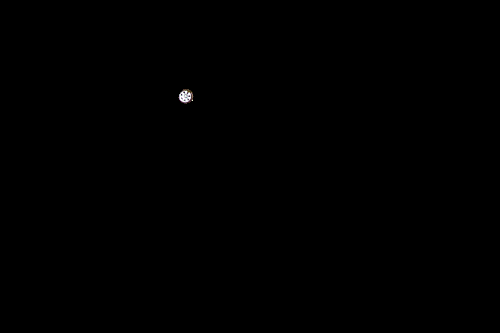

Image File:  /content/drive/MyDrive/IDL_group_project/Data/VOCdevkit/VOC2010/JPEGImages/2008_000619.jpg
Class:  car
Semantic_type:  wheel_2


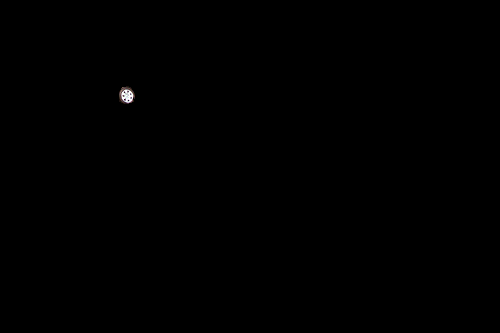

In [ ]:
for i, x in enumerate(semantic_dataloader):
  image = display_mask_image(x['semantic_mask'],x['image_name'], x['label'],x['semantic_type'])
  if i> 100:
    break

#Running Data through VGG16

In [ ]:
aeroplane_annotations_path = '/content/drive/MyDrive/IDL_group_project/Google_Colab/data/PASCAL-Part-anno-pkl/aeroplane'
bicycle_annotations_path = '/content/drive/MyDrive/IDL_group_project/Google_Colab/data/PASCAL-Part-anno-pkl/bicycle'
bus_annotations_path = '/content/drive/MyDrive/IDL_group_project/Google_Colab/data/PASCAL-Part-anno-pkl/bus'
car_annotations_path = '/content/drive/MyDrive/IDL_group_project/Google_Colab/data/PASCAL-Part-anno-pkl/car'
motorbike_annotations_path = '/content/drive/MyDrive/IDL_group_project/Google_Colab/data/PASCAL-Part-anno-pkl/motorbike'
train_annotations_path = '/content/drive/MyDrive/IDL_group_project/Google_Colab/data/PASCAL-Part-anno-pkl/train'
image_folder_dir = '/content/drive/MyDrive/IDL_group_project/Data/VOCdevkit/VOC2010/JPEGImages/'
target_labels = ['aeroplane', 'bicycle', 'bus', 'car', 'motorbike', 'train']

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)
model = models.vgg16(pretrained=True).features[:24].to(device)

all_classes_semantic_paths = [aeroplane_annotations_path,bicycle_annotations_path,bus_annotations_path,car_annotations_path,motorbike_annotations_path,train_annotations_path]
semantic_dataloader = SemanticObjectsLoader(all_classes_semantic_paths, image_folder_dir, all_classes_semantic_paths)

cpu
Total Files grabbed  3351


#Data loading and preprocessing

Get all the unmasked images

In [ ]:
duplicate_unmasked_images = []
for i, path in enumerate(tqdm(semantic_dataloader.paths)):
  with open(path, 'rb') as f:
    data = pickle.load(f)
  image_name = data['image_name']
  #We must append the full path name to image_name
  image_name = image_folder_dir + image_name + '.jpg'
  duplicate_unmasked_images.append(image_name)

 41%|████      | 1371/3351 [12:53<17:54,  1.84it/s]

In [ ]:
unmasked_images = list(set(duplicate_unmasked_images))

In [ ]:
class ImageDataset(Dataset):
    def __init__(self, file_list):
        self.file_list = file_list

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, index):
        img = Image.open(self.file_list[index])
        # re-scale the images so that the minimum of the height and width is 224 pixels
        (w,h) = img.size
        fixed_size = 224
        if h < fixed_size:
          #print("height is less than 224, h:", h)
          height_percent = (fixed_size / float(h))
          width_size = int((float(w) * float(height_percent)))
          img = img.resize((width_size, fixed_size), PIL.Image.NEAREST)
        elif w < fixed_size:
          #print("widtht is less than 224, w:", w)
          width_percent = (fixed_size / float(w))
          height_size = int((float(h) * float(width_percent)))
          img = img.resize((fixed_size, height_size), PIL.Image.NEAREST)
        img = torchvision.transforms.ToTensor()(img)        
        img = transforms.Normalize(mean = [ 0.485, 0.456, 0.406 ], std  = [ 0.229, 0.224, 0.225 ])(img)
        return img

In [ ]:
dataset = ImageDataset(unmasked_images)
#shuffle has to be "False" so that we can map the feature vector back to its corresponding image
data_loader = torch.utils.data.DataLoader(dataset=dataset,
                                                   batch_size = 1,
                                                   shuffle = False,
                                                   num_workers = 1,
                                                   pin_memory = True)

Getting feature vectors from unmasked images and store them in fv

In [ ]:
fv = []
model.eval()
with torch.no_grad():
  for X in data_loader:
    X = X.float().to(device)
    result = model(X).data.cpu().numpy()[0]
    size = result.shape[-2]*result.shape[-1]
    fv.append((result.reshape((512,size)).T))

Randomly sample 100 feature vectors per image for visaul concepts

In [ ]:
fv_sampled = []
for i in tqdm(fv):
    np.random.shuffle(i)
    fv_sampled.append(i[:100])
feature_vectors = np.concatenate(fv_sampled, axis=0)

100%|██████████| 3424/3424 [00:11<00:00, 293.93it/s]


Normalized feature vectors 

*Each row is a 512 dimensional feature vector*

In [ ]:
noramlized_fv = normalize(feature_vectors)

In [ ]:
np.save('/content/drive/MyDrive/IDL_group_project/normalized_feature_vectors', noramlized_fv)

Getting visual concepts by clustering all the feature vectors 

(visual concepts are the centorid of clusters)

In [ ]:
# typically 200 visual concepts were needed for each object
kmeans = KMeans(n_clusters=200, init='k-means++').fit(noramlized_fv)
visual_concepts = kmeans.cluster_centers_

In [ ]:
np.save('/content/drive/MyDrive/IDL_group_project/visual_concepts', visual_concepts)

This code below runs through all semantic objects from all pictures from our target classes. The label and semantic type is returned for each image. There are multiple  feature vectors returned per image

In [ ]:
%cd /content/drive/MyDrive/IDL_group_project

In [ ]:
visual_concepts = np.load(visual_concepts.npy)

In [ ]:
from numpy import linalg as LA
distance = []
for meta_dict in tqdm(semantic_dataloader):
  label, semantic_type = meta_dict['label'], meta_dict['semantic_type']
  image = convert_mask_image(meta_dict['semantic_mask'],meta_dict['image_name']).to(device)
  max_pool4_output = model(image)
  pdb.set_trace()
  non_zero_feature_vectors = np.array(get_nonzero_feature_vectors(max_pool4_output))
  for fv in non_zero_feature_vectors:
    distance.append(list(map(lambda x: LA.norm(fv - x), visual_concepts)))
  break

0it [00:00, ?it/s]

> <ipython-input-21-d7f0b1d444fc>(8)<module>()
-> non_zero_feature_vectors = np.array(get_nonzero_feature_vectors(max_pool4_output))
--Call--
> <ipython-input-6-e0fe5110e26f>(1)get_nonzero_feature_vectors()
-> def get_nonzero_feature_vectors(max_pool_layer_4_representation):
> <ipython-input-6-e0fe5110e26f>(2)get_nonzero_feature_vectors()
-> max_pool_layer_4_representation = max_pool_layer_4_representation.detach().cpu()
> <ipython-input-6-e0fe5110e26f>(3)get_nonzero_feature_vectors()
-> batch_indices, channel_indices, width_idices, height_indices = torch.nonzero(max_pool_layer_4_representation, as_tuple=True)
> <ipython-input-6-e0fe5110e26f>(4)get_nonzero_feature_vectors()
-> feature_vector_list = []
tensor([0, 0, 0,  ..., 0, 0, 0])
22521


In [ ]:
temp = np.array(non_zero_feature_vectors)

In [ ]:
from torch import linalg as LA
L2_norm = []
for fv in tqdm(non_zero_feature_vectors):
  L2_norm.append(list(map(lambda x: LA.norm(fv - x).item(), fp)))


  0%|          | 30/16546 [15:41<144:52:22, 31.58s/it]